In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [16, 8]

In [2]:
def gauss_row(size):
    arr = np.array([1,1])
    ker = np.array([1,1])
    for i in range(size-2):
        arr = np.convolve(arr,ker)
    return arr/np.sum(arr)

def reduce(img, filter_size):
    ker = gauss_row(filter_size)
    h,w = img.shape[:2]
    res = np.zeros((int(h/2),int(w/2)))
    blurred = cv2.filter2D(img,-1,ker)
    blurred = np.transpose(blurred)
    blurred = cv2.filter2D(blurred,-1,ker)
    blurred = np.transpose(blurred)
    for i in range(int(h/2)):
        for j in range(int(w/2)):
            res[i,j] = blurred[i*2,j*2]
    return res

def expand(img, filter_size):
    ker = 2*gauss_row(filter_size)
    h,w = img.shape[:2]
    res = np.zeros((h*2,w*2))
    for i in range(h):
        for j in range(w):
            res[i*2,j*2] = img[i,j]
    res = cv2.filter2D(res,-1,ker)
    res = np.transpose(res)
    res = cv2.filter2D(res,-1,ker)
    res = np.transpose(res)
    return res

In [5]:
def GaussianPyramid(im:np.ndarray, maxLevels:int, filterSize:int):
    pyramids = []
    pyramids.append(im)
    ker = gauss_row(filterSize)
    for i in range(maxLevels):
        h,w = pyramids[i].shape[:2]
        if(h/2 >= 16):
            temp = reduce(pyramids[i],filterSize)
            pyramids.append(temp)
        else:
            return pyramids,ker
    return pyramids,ker

def LaplacianPyramid(im, maxLevels, filterSize):
    pyramids = []
    gauss_pyr,ker = GaussianPyramid(im,maxLevels,filterSize)
    for i in range(maxLevels-1):
        temp = expand(gauss_pyr[i+1],filterSize)
        temp = gauss_pyr[i] - temp
        pyramids.append(temp)
    pyramids.append(gauss_pyr[maxLevels-1])
    return pyramids, ker

def LaplacianToImage(lpyr,filt)->np.ndarray:
    maxLevels = len(lpyr)
    res = lpyr[maxLevels-1]
    for i in range(1,maxLevels):
        res = expand(res,filt.shape[0]) + lpyr[maxLevels-i-1]
    return res

In [8]:
def renderPyramid(pyr)->np.ndarray:
    w = 0
    h = pyr[0].shape[0]
    for im in pyr:
        w += im.shape[0]
    res = np.zeros((h,w))
    start = 0
    for j in range(len(pyr)):
        curr = pyr[j]
        size = curr.shape[0]
        res[0:size,start:start+size] = curr
        start += size
    return res

def displayPyramid(pyr)->None:
    plt.imshow(renderPyramid(pyr),'gray')

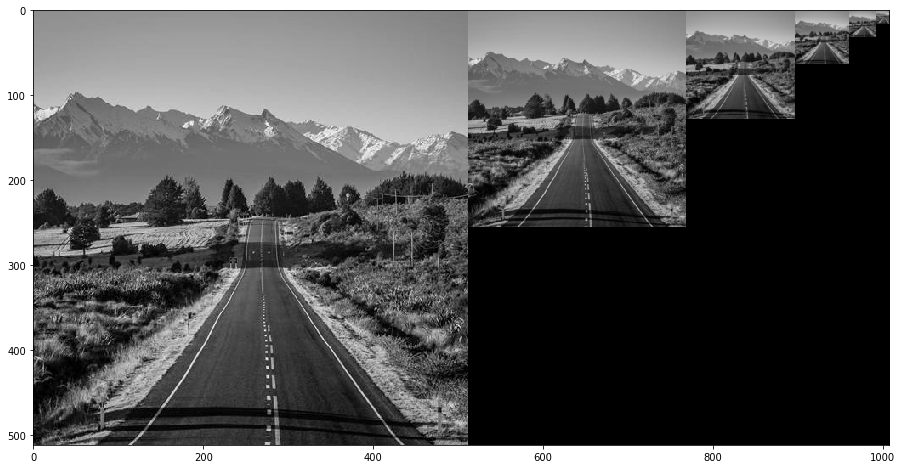

In [11]:
img = cv2.imread('images/road.jpg',0)
filterSize = 3
maxLevels = 6
pyr,_ = GaussianPyramid(img,maxLevels,filterSize)
# pyr2,ker = LaplacianPyramid(img,maxLevels,filterSize)
displayPyramid(pyr)

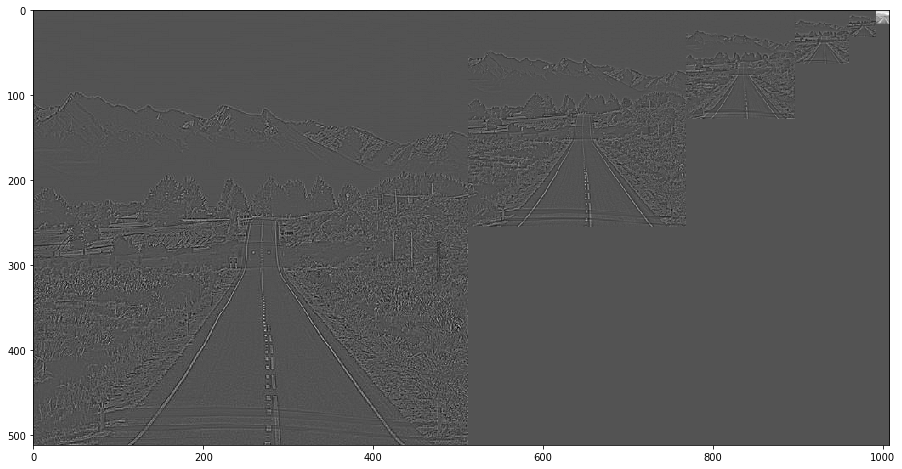

In [15]:
img = cv2.imread('images/road.jpg',0)
filterSize = 3
maxLevels = 6
pyr,_ = LaplacianPyramid(img,maxLevels,filterSize)
displayPyramid(pyr)

In [16]:
def pyramidBlending(im1:np.ndarray, im2:np.ndarray, mask:np.ndarray, maxLevels:int, filterSizeIm:int, filterSizeMask:int)->np.ndarray:
    l1,ker = LaplacianPyramid(im1,maxLevels,filterSizeIm)
    l2,_ = LaplacianPyramid(im2,maxLevels,filterSizeIm)
    gm,_ = GaussianPyramid(mask,maxLevels,filterSizeMask)
    maxLevels = len(l1)
    lout = []
    for k in range(maxLevels):
        res = gm[k]*l1[k]+(1-gm[k])*l2[k]
        lout.append(res)
    return LaplacianToImage(lout,ker)

def pyramidBlendingRGB(im1:np.ndarray, im2:np.ndarray, mask:np.ndarray, maxLevels:int, filterSizeIm:int, filterSizeMask:int)->np.ndarray:
    rblend = pyramidBlending(im1[:,:,0],im2[:,:,0],mask,maxLevels,filterSizeIm,filterSizeMask)
    gblend = pyramidBlending(im1[:,:,1],im2[:,:,1],mask,maxLevels,filterSizeIm,filterSizeMask)
    bblend = pyramidBlending(im1[:,:,2],im2[:,:,2],mask,maxLevels,filterSizeIm,filterSizeMask)
    res = np.zeros(im1.shape)
    res[:,:,0] = rblend/255
    res[:,:,1] = gblend/255
    res[:,:,2] = bblend/255
    return res

In [20]:
dude1 = cv2.imread('cv_ex3/dude1.png')
dude1 = cv2.cvtColor(dude1,cv2.COLOR_BGR2RGB)
dude2 = cv2.imread('cv_ex3/dude2.png')
dude2 = cv2.cvtColor(dude2,cv2.COLOR_BGR2RGB)
mask = cv2.imread('cv_ex3/mask.png',0)//255
res = pyramidBlendingRGB(dude1,dude2,mask,3,5,5)

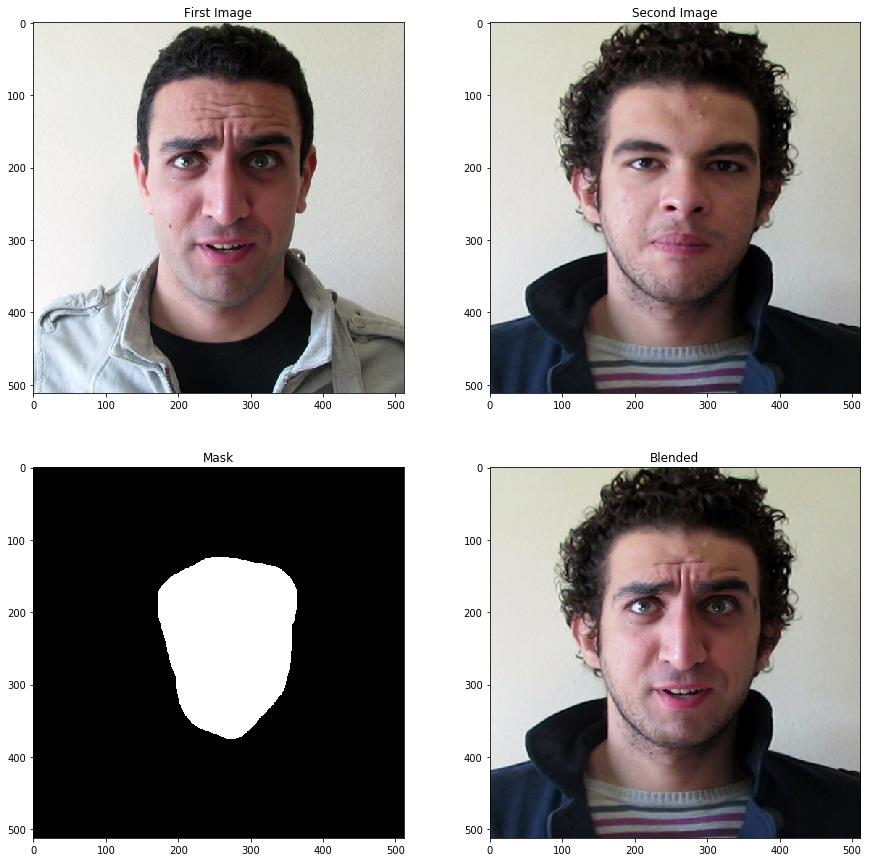

In [23]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(2,2,1)
plt.imshow(dude1,'gray')
a.set_title('First Image')
a = fig.add_subplot(2,2,2)
plt.imshow(dude2,'gray')
a.set_title('Second Image')
a = fig.add_subplot(2,2,3)
plt.imshow(mask,'gray')
a.set_title('Mask')
a = fig.add_subplot(2,2,4)
plt.imshow(res,'gray')
a.set_title('Blended')
plt.show()